# TSP problem using CE Method 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
class TSPCrossEntropy(object):
    """Méthode de la cross entropie pour résoudre le problème TSP  
    
    Attributs à entrer par l'utilisateur:
        c: matrice de poids pour les trajets entre les villes.
        k: nombre de simulations pour chaque update de la forme k*(nombre villes)^2 (int)
        perc: percentile fixé dans l'algo (int entre 1 et 100) 
        seed: graine pour fixer l'aléatoire (int)
        stop: critère d'arrêt (on s'arrète quand les d derniers quantiles sont les mêmes)
        alpha: "smoothing" parameter.
        
    Attributs:
        n: nombre de villes
        N: nombre de simulations pour chaque update
        p: matrice de transition entre les villes (pij proba de passer de la ville i à la ville j),
           initialisée par des Dirichlet uniformes
        p_old: version de p de l'update précédent
        
    Méthodes: (Voir aide spécifique à chaque méthode pour plus de détails)
        generate_tours: génère les "tours" selon la matrice p
        S: calcule le score d'un "tour"
        contruct_mult : voir présentation
        
    """
    
    def __init__(self,c,k,perc=10, seed=None, alpha = 0.9,stop=5, show_p=5,show_q=10):
        """Constructeur de la classe TSPCrossEntropy."""
        self.c = c
        self.n = c.shape[0]
        self.N = k * self.n**2
        self.perc = perc
        self.seed = seed
        self.alpha = alpha
        self.stop=stop
        self.p=(np.ones((self.n,self.n))-np.eye(self.n))*(1/float(self.n-1))
        self.p_old = self.p
        self.show_p = show_p
        self.show_q = show_q
        
    def generate_tours(self):
        """Génère N tours selon les probabilités de transition de p
        Retourne une matrice de taille N*n où chaque ligne est un tour"""
    
        #première ville toujours 0 (mieux de prendre 0 que 1 pour les indices des matrices)
        tours = np.zeros((self.N,(self.n+1)),dtype=int)

        for obs in range(self.N):
            
            p = self.p.copy()
            for step in range(1,(self.n)):
                p[:,tours[obs,(step-1)]] = 0 #on met la colonne à zéro car on est déjà passé par la ville
                
                with np.errstate(invalid='ignore', divide='ignore'): #pour shut off les warnings
                    p = (np.divide(p.T,p.sum(axis=1))).T #on renormalise pour que les colonnes somment à 1
                
                #on génère une multinomiale pour trouver la prochaine ville
                tours[obs,step] = np.random.choice(np.arange(self.n),1, p=p[tours[obs,(step-1)],:])[0]
                
            tours[obs,-1] = 0 #on revient à la ville 0
            
        return tours
        
    def S(self,x):
        '''Calcule la performance du tour par rapport à la matrice de poids c'''
        score = 0
        for i in range(len(x)-1):
            score += self.c[x[i],x[i+1]] #cout d'aller d'une ville à une autre 

        return score

    
    def update(self,x, score,q):
        '''Permet de faire l'update "smooth" des probas de transition pij
        la methode "smooth" evite les problemes avec des 0 au mauvais endroits'''
        self.p_old = self.p.copy()
        p =  np.zeros_like(self.p)
        
        x = x[score<=q,:]
        
        for obs in range(x.shape[0]):
            
            for idx in range(x.shape[1]-1):
                i = x[obs,idx]
                j = x[obs,idx+1]
                p[i,j] += 1

        p = np.divide(p,float(x.shape[0]))
        
        self.p = self.alpha*p + (1-self.alpha)*self.p_old
             
        return None
    
    
    def show_prob(self):
        plt.figure(figsize=(8,8))
        plt.matshow(self.p,fignum=1)
        plt.xlabel('j')
        plt.ylabel('i')
        plt.grid('off')
        plt.colorbar()
        plt.show()
    
 
    def CE_fit(self):
        if self.seed:
            #fixe aléa
            np.random.seed(self.seed)
              
        #Critére d'arrêt : les 'stop' derniers quantiles calculés sont les mêmes, q_memory les stockent
        #q_memory = np.zeros(self.stop)
        q_memory = np.array([])
        
        epoch = 0
        best_score = np.infty
        best_solution = None

        while True:
            epoch += 1
            print("Epoch {}".format(epoch))
            
            #genere des "tours"
            x = self.generate_tours().astype(np.int)
            
            #calcul du score pour chaque tour
            score = np.apply_along_axis(lambda x: self.S(x),1,x)
            
            #quantile
            q = np.percentile(score,self.perc)
            
            best = np.min(score)
            if best < best_score: 
                best_score = best
                best_solution = x[np.argmin(score),:]
                    
            print("Quantile : {}, Meilleur score : {}".format(q,best))
            
            #on update nos quantiles pour le critère d'arrêt dans la memory
            #q_memory[:-1] = q_memory[1:]
            #q_memory[-1] = q
            q_memory = np.append(q_memory,[q])
                        
            if epoch%self.show_p==0: 
                self.show_prob()
                
            if epoch%self.show_q==0: 
                plt.plot(q_memory)
                plt.show()
                
            #smooth update
            self.update(x,score,q)

            #si les 5 derniers quantiles sont les mêmes ont arrête
            #if len(set(q_memory))==1 : break 
            if len(q_memory)>5:
                if len(set(q_memory[-self.stop:]))==1 : break      
        
        #Affichage finale
        self.show_prob()
        plt.plot(q_memory)
        plt.show()
        print("final epoch {}, dernier quantile : {}".format(epoch,q))
        print("Meilleur score {}, solution : {}".format(best_score,best_solution))
                
        return best_solution

# Application Indian cities

In [8]:
def CE_solution(c,k=10,perc=1):
    TSP = TSPCrossEntropy(c,k=k,perc=perc)
    TSP.CE_fit()
    return TSP

## Indian cities

In [9]:
data = pd.read_csv('distance.txt', header = None,delimiter='\t')

In [10]:
#on ne prend pas toutes les villes, c'est trop gros
k = 11
c = data.values[:k,:k]
c.shape

(11, 11)

In [7]:
#c

Epoch 1
Quantile : 80337.5, Meilleur score : 60818
Epoch 2
Quantile : 57120.73, Meilleur score : 48194
Epoch 3
Quantile : 50485.0, Meilleur score : 46927
Epoch 4
Quantile : 46530.0, Meilleur score : 46530
Epoch 5
Quantile : 46530.0, Meilleur score : 46530


/usr/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


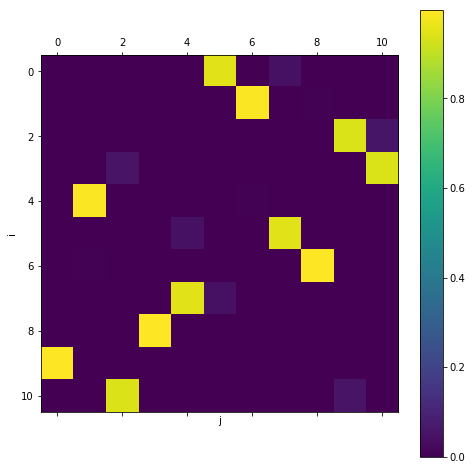

Epoch 6
Quantile : 46530.0, Meilleur score : 46530
Epoch 7
Quantile : 46530.0, Meilleur score : 46530
Epoch 8
Quantile : 46530.0, Meilleur score : 46530


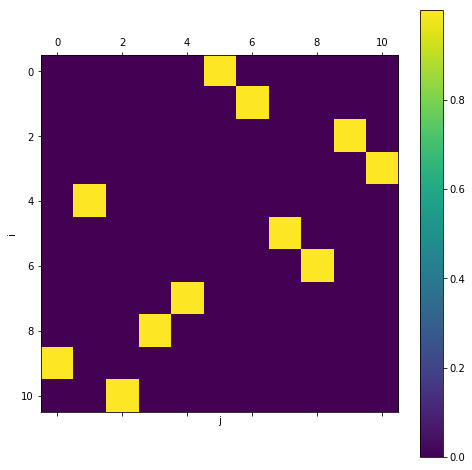

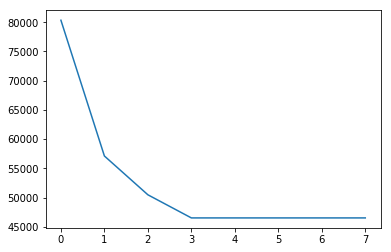

final epoch 8, dernier quantile : 46530.0
Meilleur score 46530, solution : [ 0  5  7  4  1  6  8  3 10  2  9  0]
CPU times: user 6.59 s, sys: 123 ms, total: 6.71 s
Wall time: 6.26 s


In [11]:
%%time
TSP = CE_solution(c)

In [12]:
from itertools import permutations

In [13]:
def best_score(TSP):
    mini = np.infty
    for tours in permutations(range(1,TSP.n)):
        s = TSP.S((0,) + tours + (0,))
        if s< mini:
            mini = s
    return mini

In [14]:
best_score(TSP)

46530

## GR17

GR17 is a set of 17 cities, from TSPLIB. The minimal tour has length 2085.

Meilleur score obtenu par l'algo : 2090

In [15]:
c = np.loadtxt('https://people.sc.fsu.edu/~jburkardt/datasets/tsp/gr17_d.txt')

In [16]:
c.shape

(17, 17)

Epoch 1
Quantile : 3641.89, Meilleur score : 3205.0
Epoch 2
Quantile : 2923.9, Meilleur score : 2431.0
Epoch 3
Quantile : 2524.89, Meilleur score : 2275.0
Epoch 4
Quantile : 2316.89, Meilleur score : 2167.0
Epoch 5
Quantile : 2193.0, Meilleur score : 2123.0


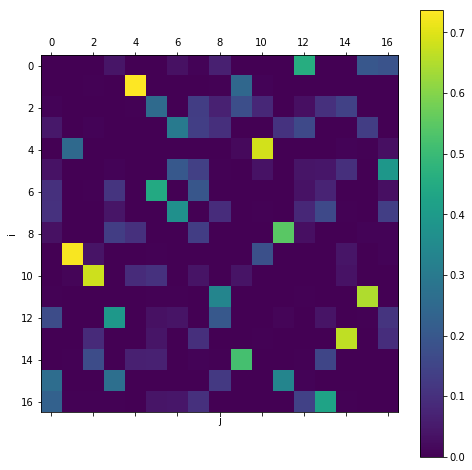

Epoch 6
Quantile : 2103.0, Meilleur score : 2090.0
Epoch 7
Quantile : 2090.0, Meilleur score : 2090.0
Epoch 8
Quantile : 2090.0, Meilleur score : 2090.0
Epoch 9
Quantile : 2090.0, Meilleur score : 2090.0
Epoch 10
Quantile : 2090.0, Meilleur score : 2090.0


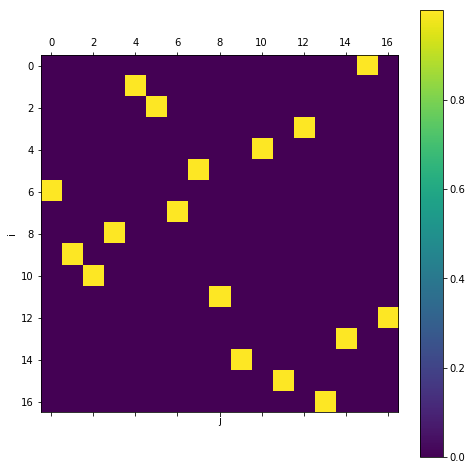

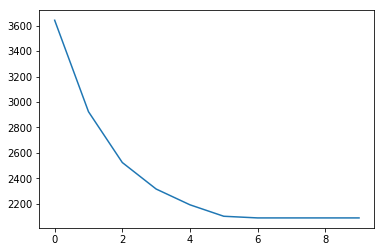

Epoch 11
Quantile : 2090.0, Meilleur score : 2090.0


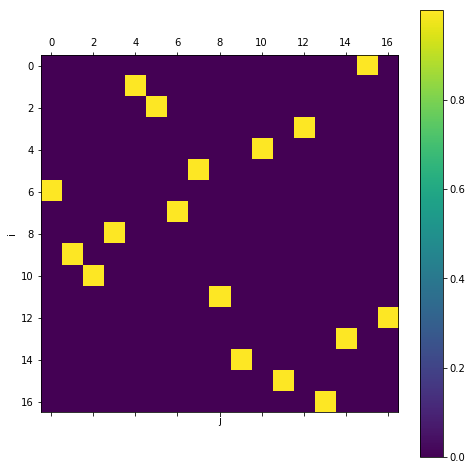

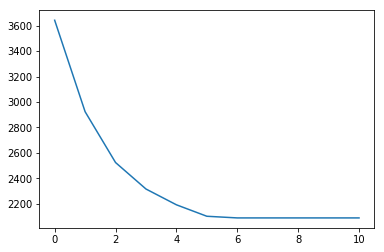

final epoch 11, dernier quantile : 2090.0
Meilleur score 2090.0, solution : [ 0 15 11  8  3 12 16 13 14  9  1  4 10  2  5  7  6  0]
CPU times: user 32.4 s, sys: 433 ms, total: 32.8 s
Wall time: 32.2 s


In [17]:
%%time
TSP = CE_solution(c)

## ATT48

ATT48 is a set of 48 cities (US state capitals) from TSPLIB. The minimal tour has length 10628.

Meilleur score obtenu par l'algo : 

Sur ce dataset on est tres loin de la solution optimale !!!!!! (pourquoi? )

In [19]:
c = np.loadtxt('https://people.sc.fsu.edu/~jburkardt/datasets/tsp/att48_d.txt')
c.shape

(48, 48)

In [20]:
%%time
TSP = CE_solution(c)

Epoch 1


KeyboardInterrupt: 

# Dataset ft53 du papier

In [17]:
def read_atsp(url):
    
    '''
    Motivation: for some reason, the .atsp-file has 212 rows (not 53!). So,
    it needs to be manually processed.
    
    The function takes url (string) and returns a numpy array
    with edge costs.
    '''
    
    # Reads external file with numpy, 
    # spicifies the number of lines to skip,
    # initializes a lst to write to:  
    ds = np.DataSource()
    input_f = ds.open(url)
    num_lines_skip = 6
    lst = []
    
    # Appends each line to a list except for unuseful info:  
    for i, line in enumerate(input_f):
    
        if (i <= num_lines_skip) or ('EOF' in line):
            continue

        else:
            lst.append(line)

    # Concatenate each read line into one string,
    # removes all carriage returns and trailling whitespaces:  
    lst = ''.join(lst).replace('\n', '').split()
    
    # Return numpy array, reshape it into 53 x 53 matrix:  
    return np.array(lst, dtype=int).reshape(53, 53)

In [18]:
c = read_atsp('http://elib.zib.de/pub/mp-testdata/tsp/tsplib/atsp/ft53.atsp')

In [19]:
c.shape

(53, 53)

In [73]:
for i in range(c.shape[0]):
    c[i,i] = 0

In [74]:
c

array([[   0,  223,  210, ...,  357,  420,  344],
       [  58,    0,  179, ...,  300,  214,  314],
       [  60,  109,    0, ...,  201,  302,  190],
       ...,
       [1504, 1464, 1629, ...,    0,  272,  159],
       [1505, 1534, 1545, ...,  106,    0,  240],
       [1520, 1472, 1612, ...,   29,  118,    0]])

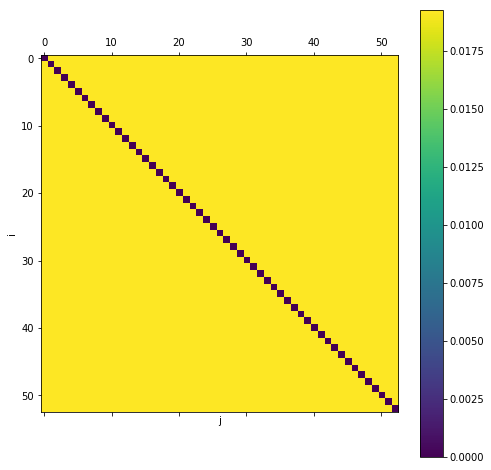

Epoch 1
Gamma : 24106.0, Best Score 19982


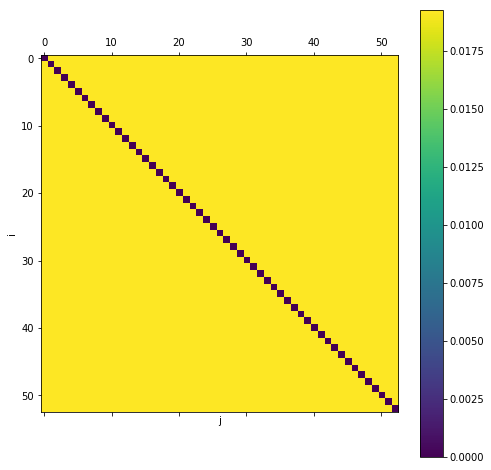

Epoch 2
Gamma : 22150.0, Best Score 18504


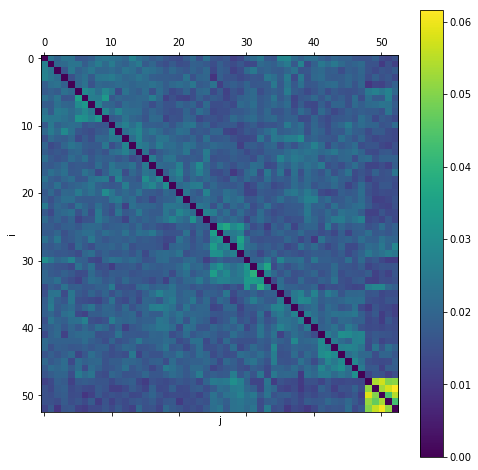

Epoch 3
Gamma : 20339.45, Best Score 16791


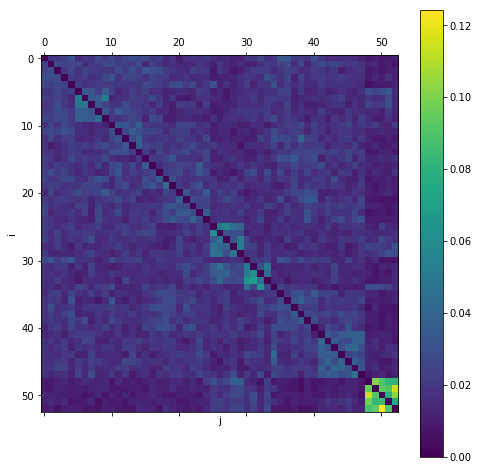

Epoch 4
Gamma : 18831.45, Best Score 15772


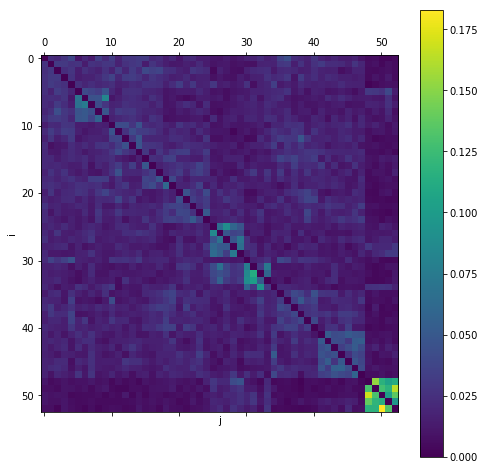

Epoch 5
Gamma : 17511.0, Best Score 14224


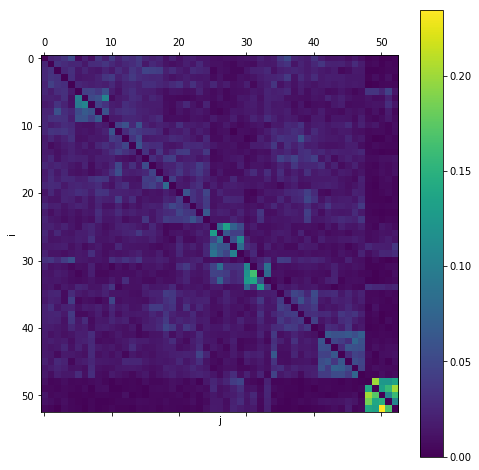

Epoch 6
Gamma : 16416.45, Best Score 13853


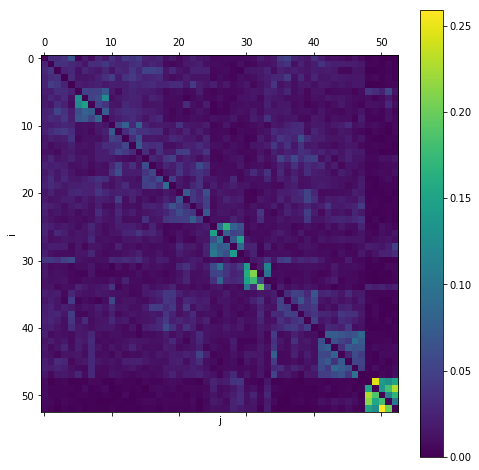

Epoch 7
Gamma : 15482.45, Best Score 13072


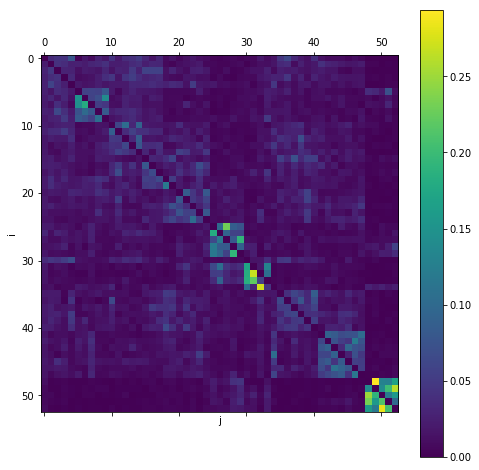

Epoch 8
Gamma : 14690.45, Best Score 12368


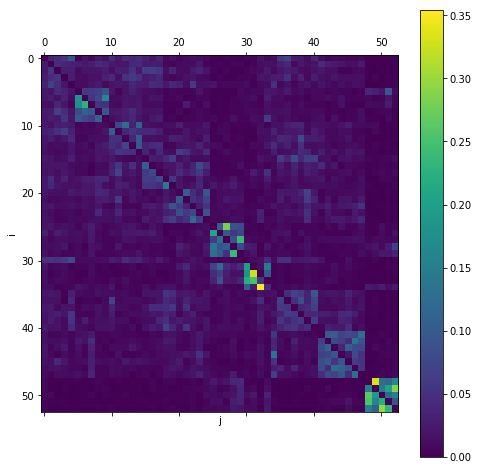

Epoch 9
Gamma : 14042.45, Best Score 11462


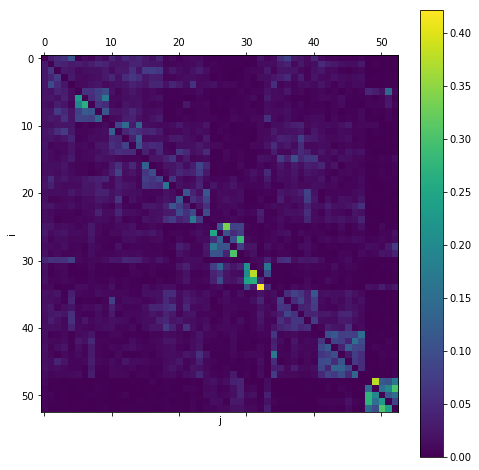

Epoch 10
Gamma : 13475.45, Best Score 10688


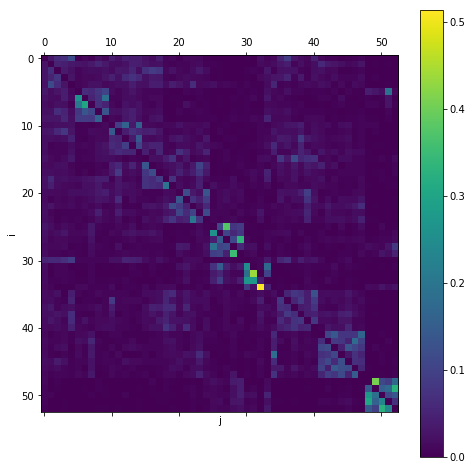

Epoch 11
Gamma : 12991.0, Best Score 10813


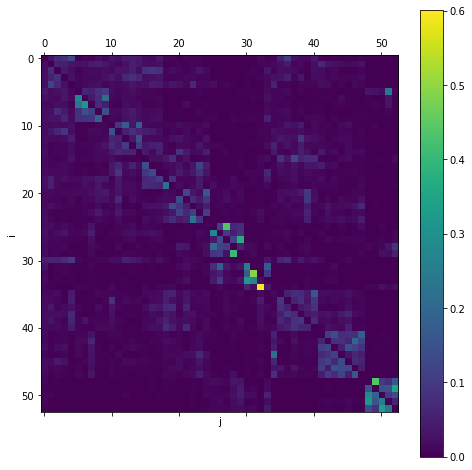

Epoch 12
Gamma : 12562.45, Best Score 9995


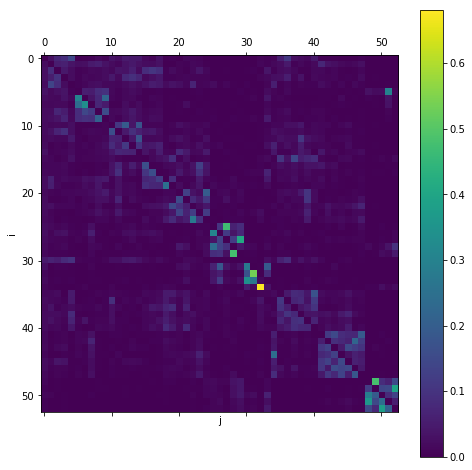

Epoch 13
Gamma : 12208.45, Best Score 10262


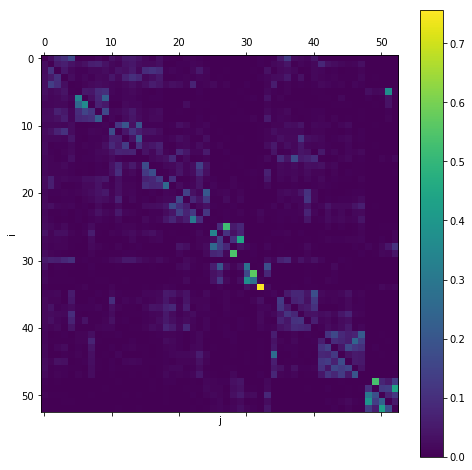

Epoch 14
Gamma : 11852.0, Best Score 9539


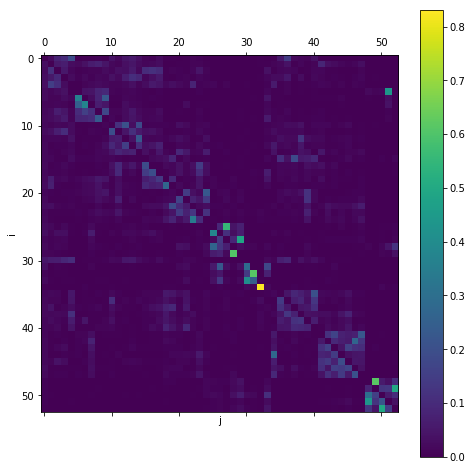

Epoch 15
Gamma : 11553.45, Best Score 9390


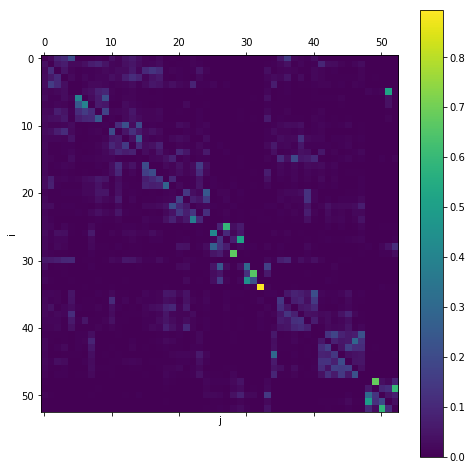

Epoch 16
Gamma : 11248.0, Best Score 9638


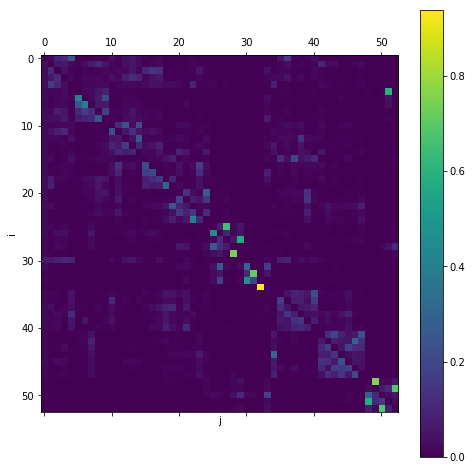

Epoch 17
Gamma : 10925.0, Best Score 8841


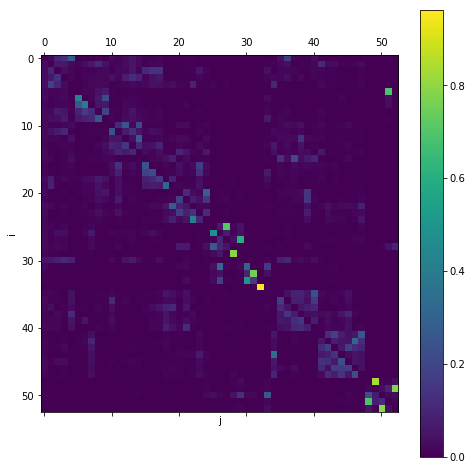

Epoch 18
Gamma : 10599.0, Best Score 8824


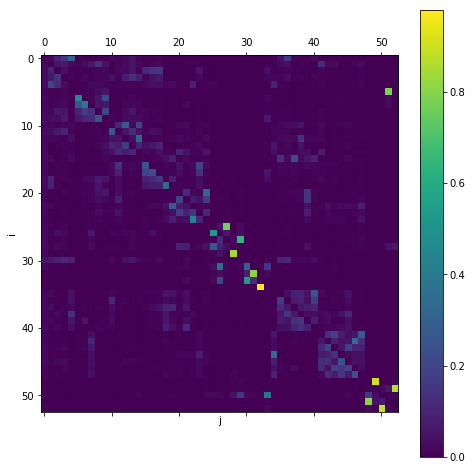

Epoch 19
Gamma : 10262.0, Best Score 8729


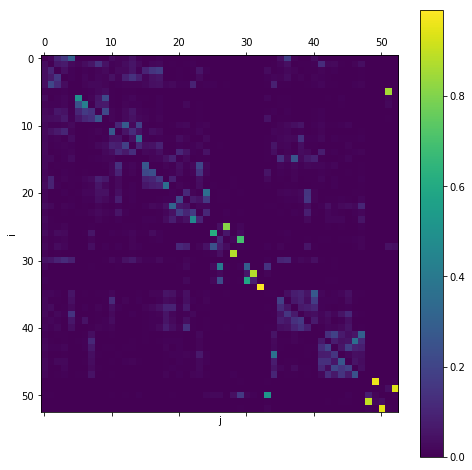

Epoch 20
Gamma : 9939.0, Best Score 8514


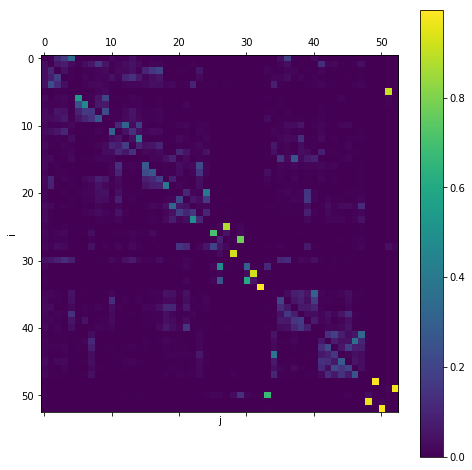

Epoch 21
Gamma : 9675.0, Best Score 8449


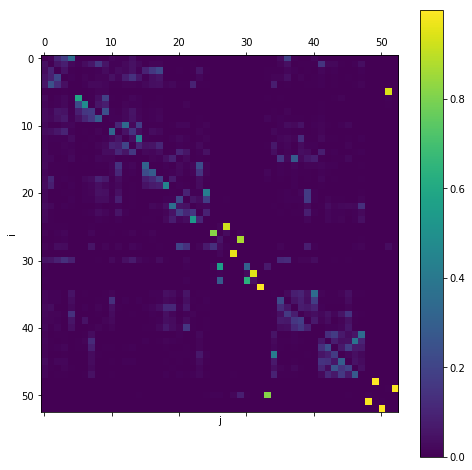

Epoch 22
Gamma : 9423.0, Best Score 8232


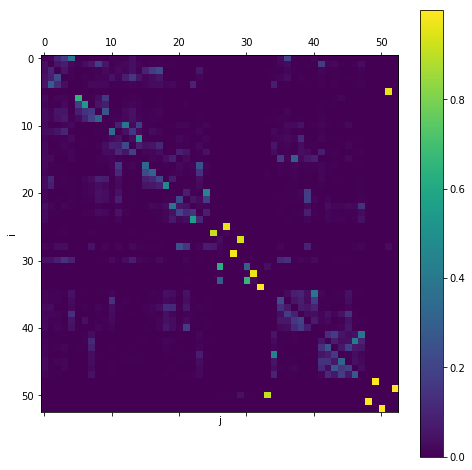

Epoch 23
Gamma : 9226.0, Best Score 7961


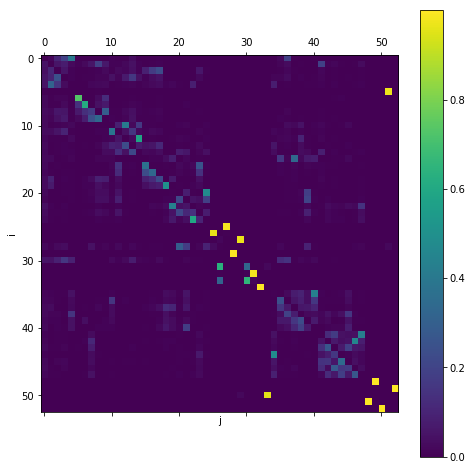

Epoch 24
Gamma : 9051.45, Best Score 7985


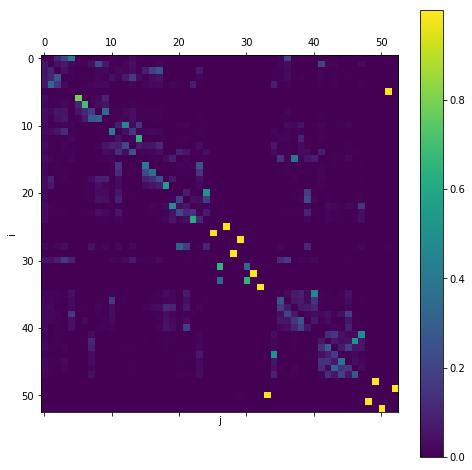

Epoch 25
Gamma : 8878.45, Best Score 7972


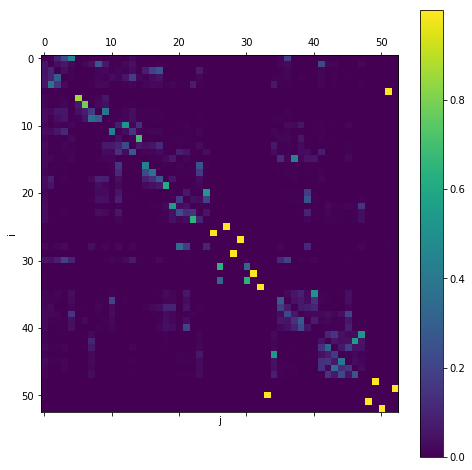

Epoch 26
Gamma : 8735.45, Best Score 7757


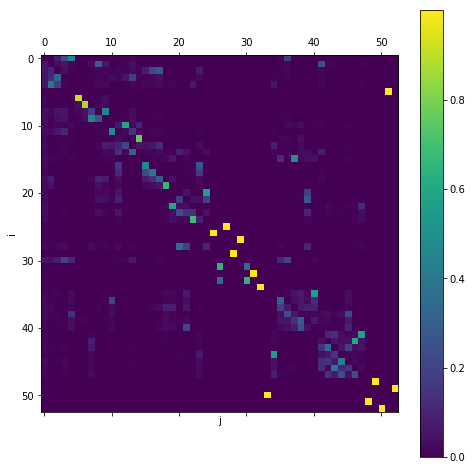

Epoch 27
Gamma : 8592.0, Best Score 7719


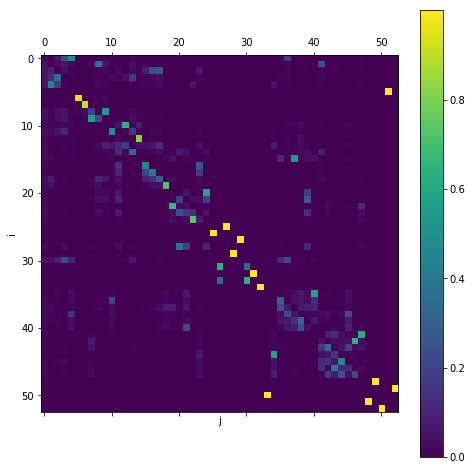

Epoch 28
Gamma : 8443.0, Best Score 7419


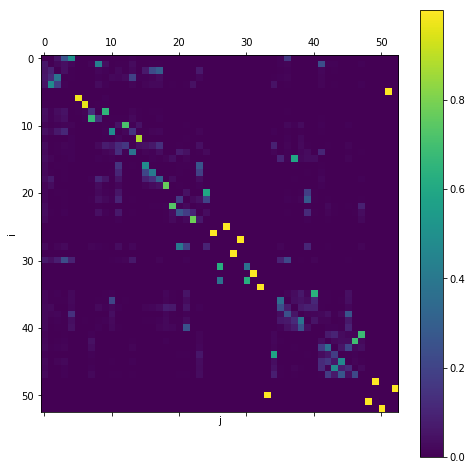

Epoch 29
Gamma : 8307.0, Best Score 7424


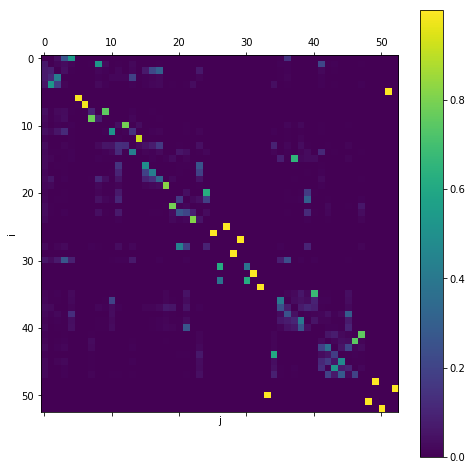

Epoch 30
Gamma : 8171.0, Best Score 7347


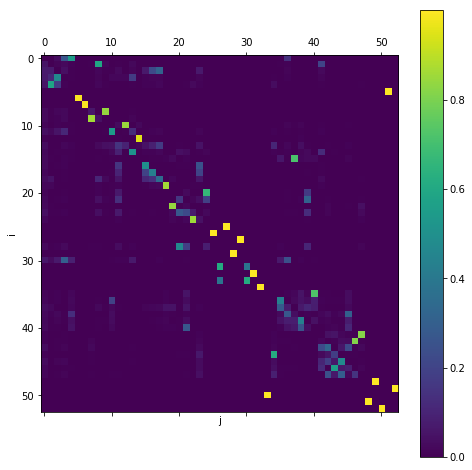

Epoch 31
Gamma : 8039.0, Best Score 7269


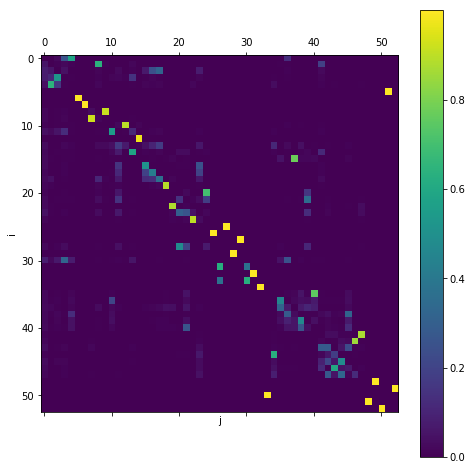

Epoch 32
Gamma : 7926.0, Best Score 7235


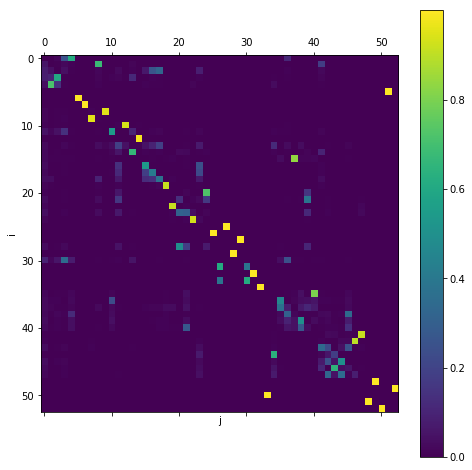

Epoch 33
Gamma : 7820.0, Best Score 7253


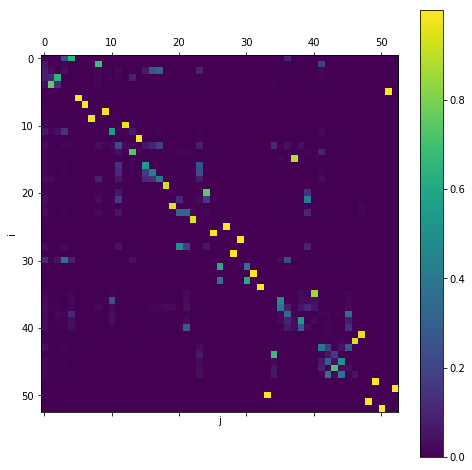

Epoch 34
Gamma : 7732.45, Best Score 7157


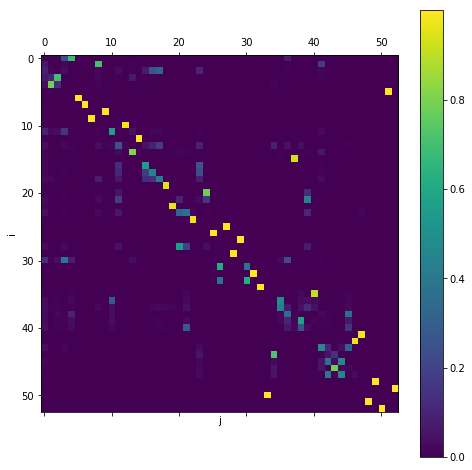

Epoch 35
Gamma : 7633.0, Best Score 7140


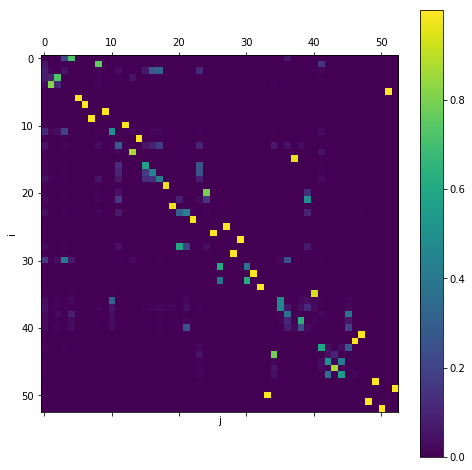

Epoch 36
Gamma : 7528.0, Best Score 7139


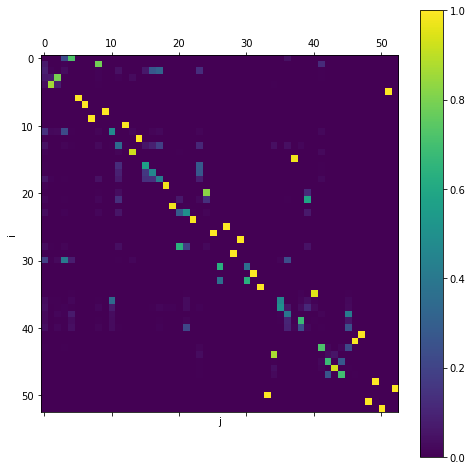

Epoch 37
Gamma : 7422.0, Best Score 7111


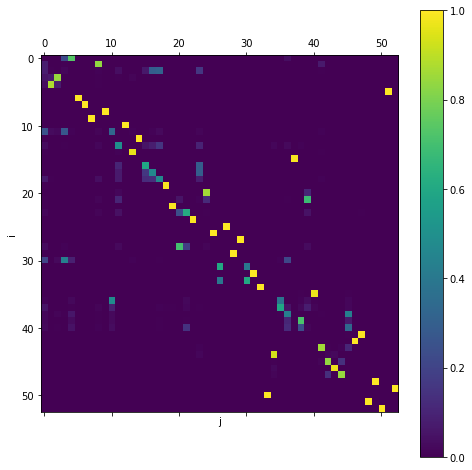

Epoch 38
Gamma : 7302.0, Best Score 7111


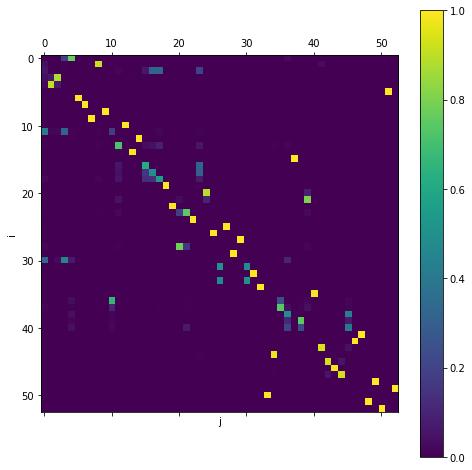

Epoch 39
Gamma : 7170.0, Best Score 7111


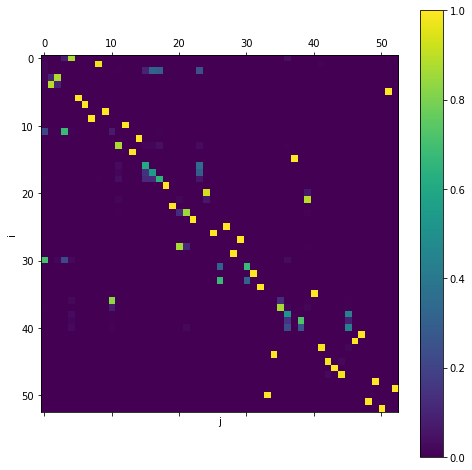

Epoch 40
Gamma : 7157.0, Best Score 7111


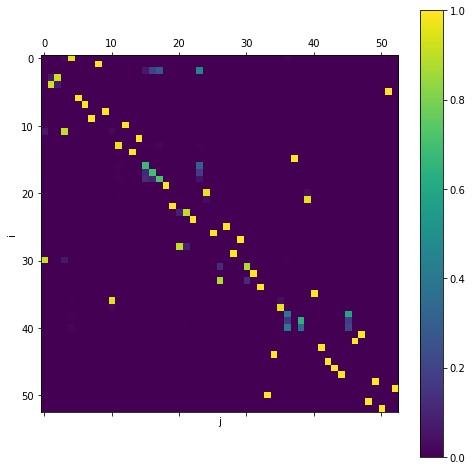

Epoch 41
Gamma : 7157.0, Best Score 7111


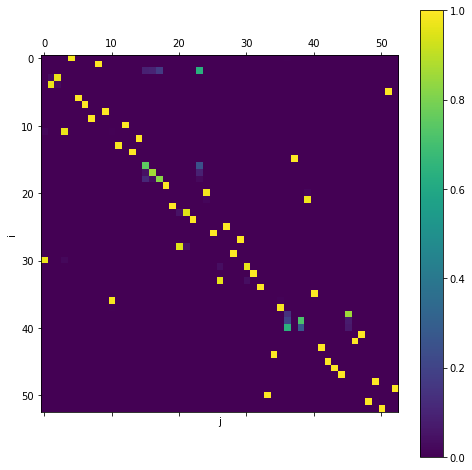

Epoch 42
Gamma : 7157.0, Best Score 7111


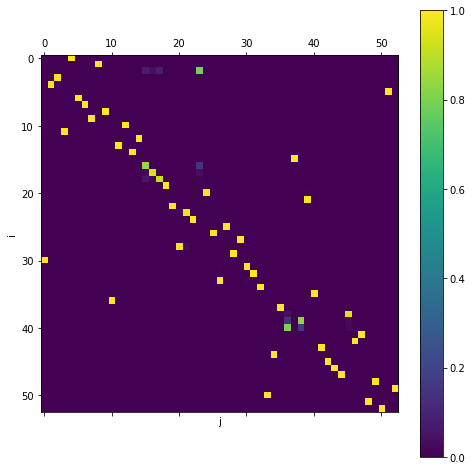

Epoch 43
Gamma : 7157.0, Best Score 7129


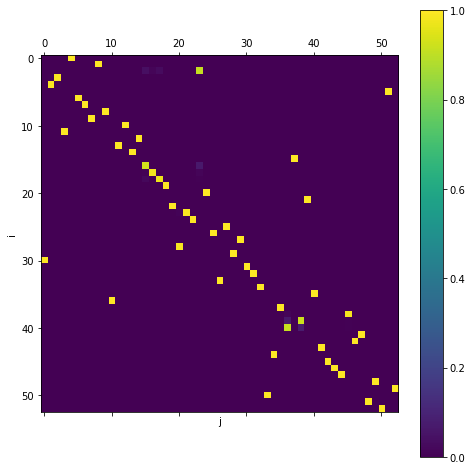

Epoch 44
Gamma : 7157.0, Best Score 7129


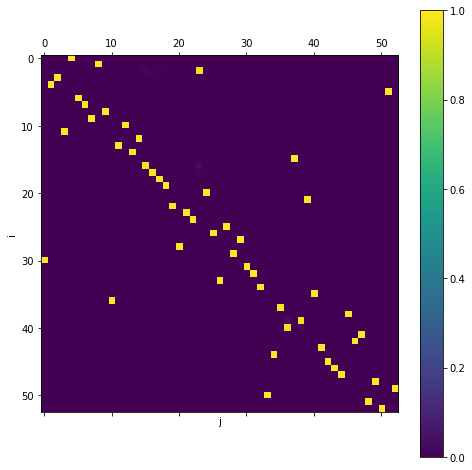

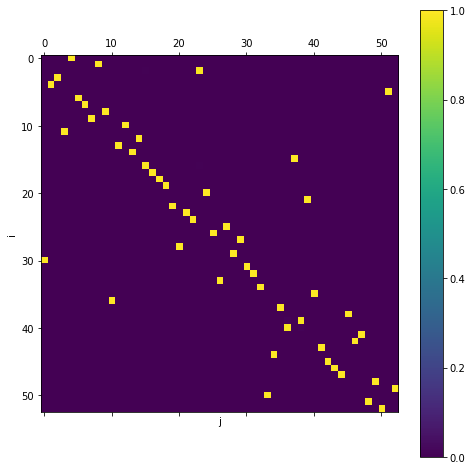

final epoch 44, optimal gamma : 7157.0
CPU times: user 1h 3min 31s, sys: 9.95 s, total: 1h 3min 41s
Wall time: 1h 21min 21s


In [78]:
%%time
TSP = CE_solution(c)

# Baseball Map

In [80]:
c = np.loadtxt("baseball.txt")

In [82]:
c.shape

(30, 30)

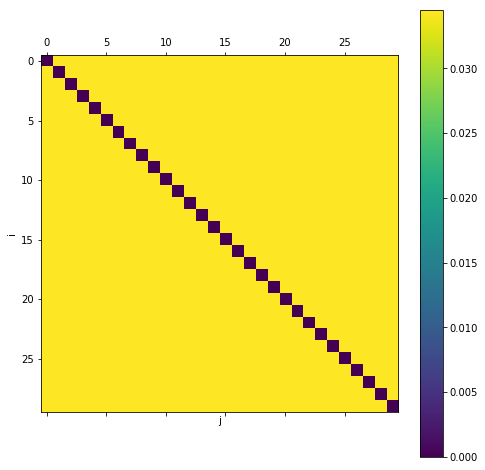

Epoch 1
Gamma : 27510.95, Best Score 22360.0


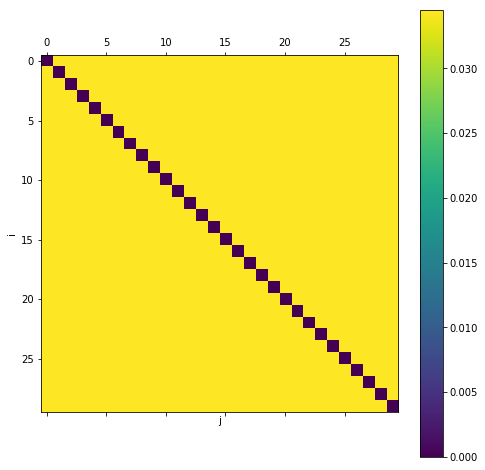

Epoch 2
Gamma : 22647.7, Best Score 19863.0


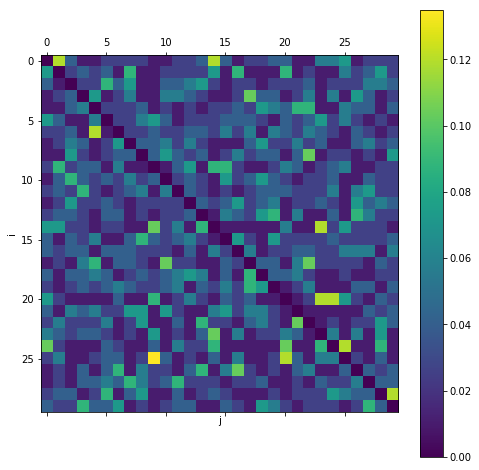

Epoch 3
Gamma : 19222.98, Best Score 14783.0


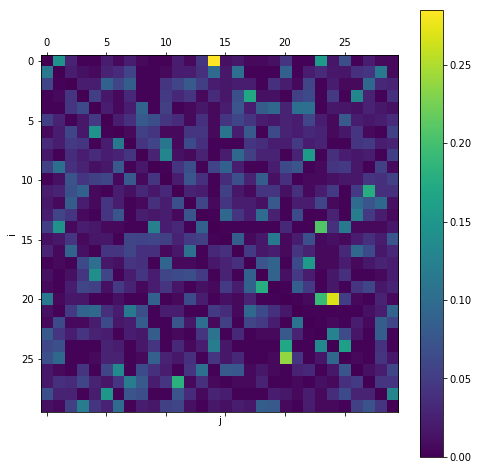

Epoch 4
Gamma : 16633.91, Best Score 14920.0


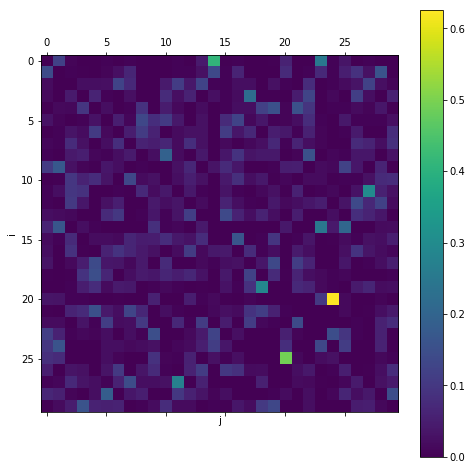

Epoch 5
Gamma : 15274.84, Best Score 12297.0


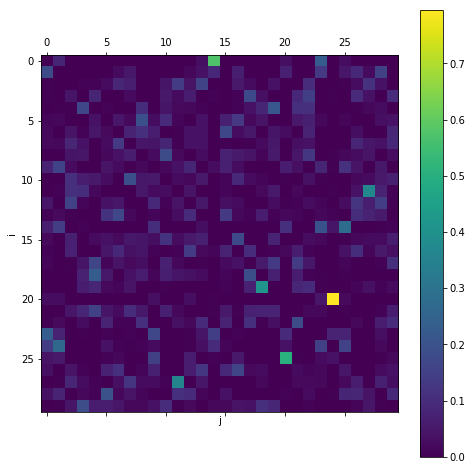

Epoch 6
Gamma : 14236.93, Best Score 12676.0


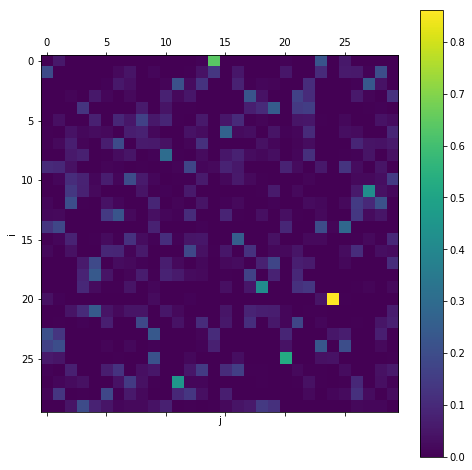

Epoch 7
Gamma : 13344.69, Best Score 11447.0


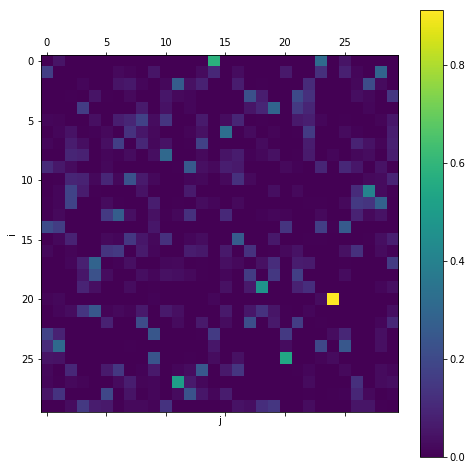

Epoch 8
Gamma : 12648.98, Best Score 11048.0


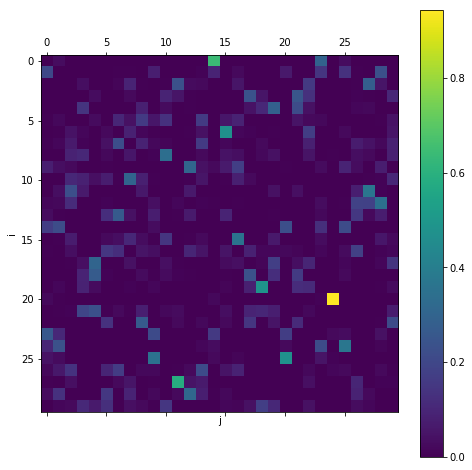

Epoch 9
Gamma : 12143.88, Best Score 11132.0


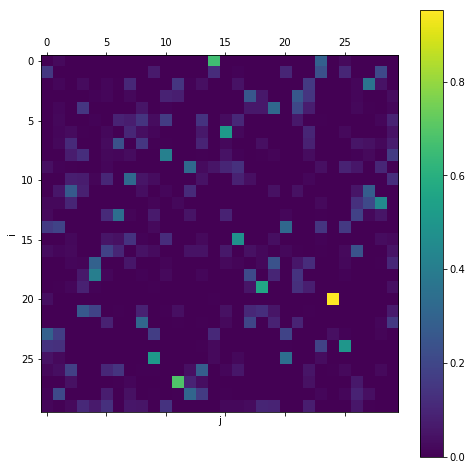

Epoch 10
Gamma : 11840.93, Best Score 10336.0


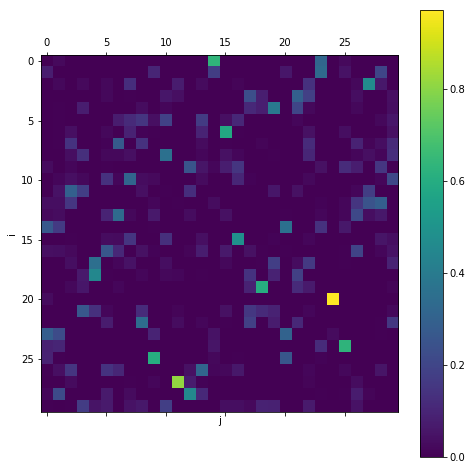

Epoch 11
Gamma : 11565.96, Best Score 10315.0


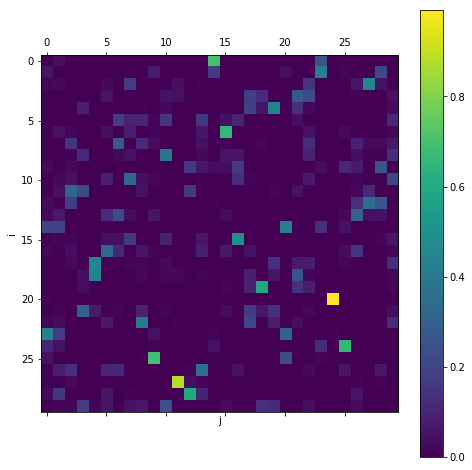

Epoch 12
Gamma : 11298.9, Best Score 10086.0


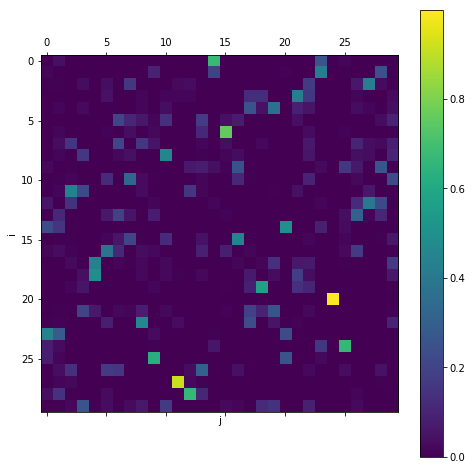

Epoch 13
Gamma : 10805.97, Best Score 9694.0


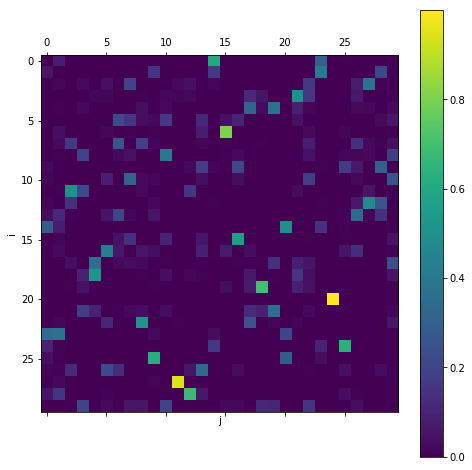

Epoch 14
Gamma : 10572.86, Best Score 9489.0


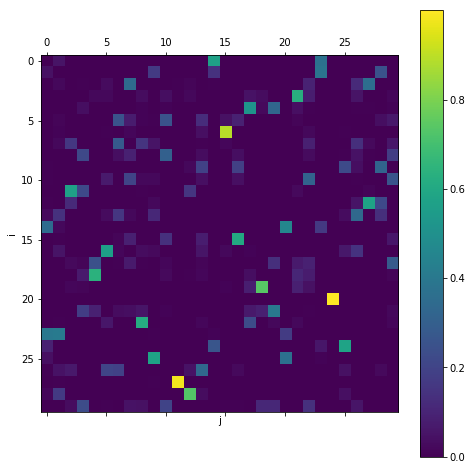

Epoch 15
Gamma : 10137.93, Best Score 9429.0


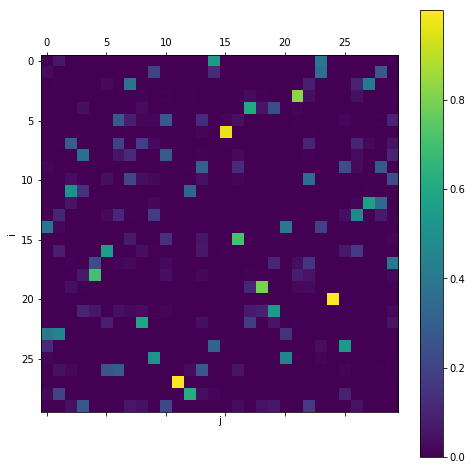

Epoch 16
Gamma : 9486.0, Best Score 9198.0


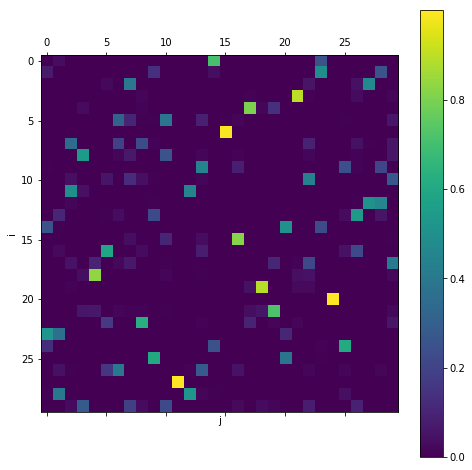

Epoch 17
Gamma : 9253.0, Best Score 9198.0


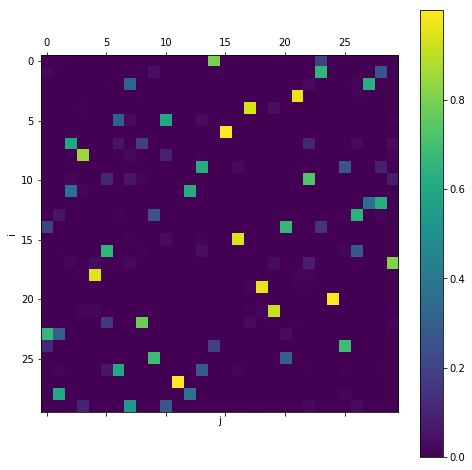

Epoch 18
Gamma : 9198.0, Best Score 9198.0


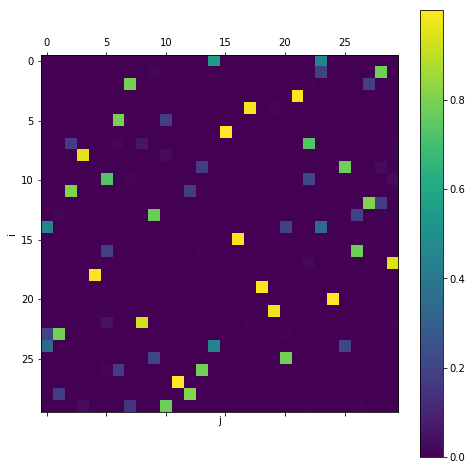

Epoch 19
Gamma : 9198.0, Best Score 9198.0


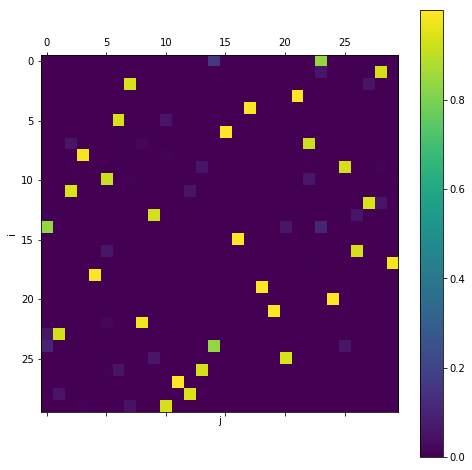

Epoch 20
Gamma : 9198.0, Best Score 9198.0


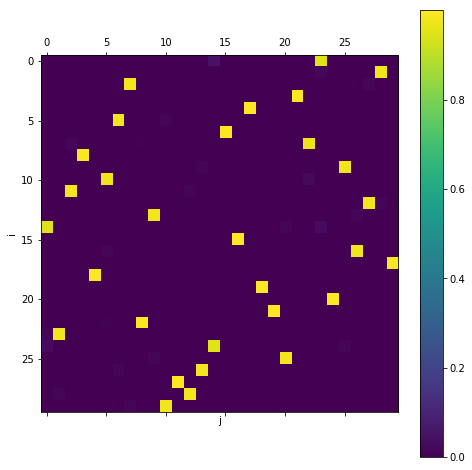

Epoch 21
Gamma : 9198.0, Best Score 9198.0


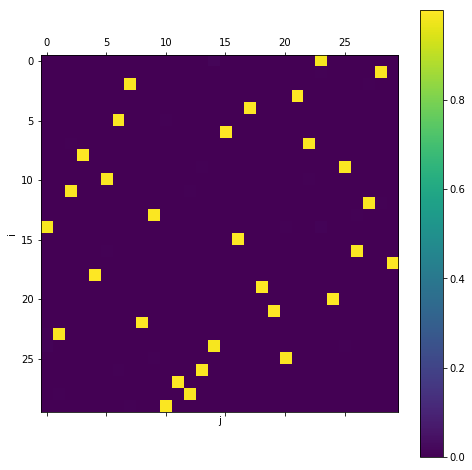

Epoch 22
Gamma : 9198.0, Best Score 9198.0


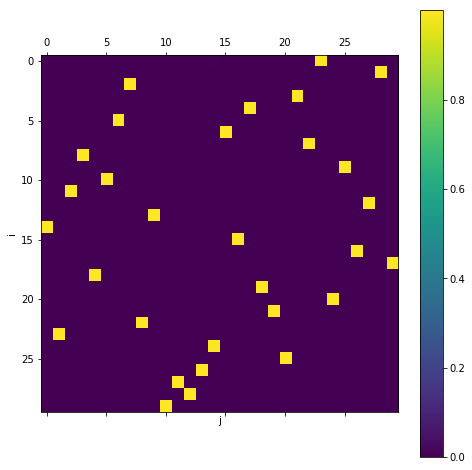

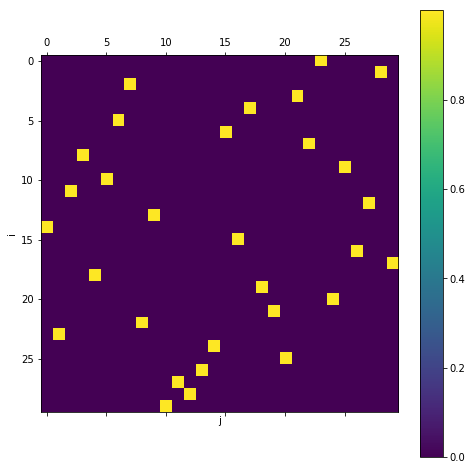

final epoch 22, optimal gamma : 9198.0
CPU times: user 2min 54s, sys: 1.72 s, total: 2min 56s
Wall time: 2min 51s


In [85]:
%%time
TSP = CE_solution(c)